# Time series - multivariate prediction, data preprocessing

In this example, we will use `pandas` to load and prepare dataset for multivariate prediction.

The dataset is from Prague airport daily weather measurements.

In [0]:
import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.max_rows = 30

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

First, let's prepare some constants

In [0]:
days = {str(y) for y in range(1, 32)}
months = dict(zip(
    ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    range(1, 13)
))            
years = {str(y) for y in range(1996, 2018)}

rain_flags = ['Thunderstorm', 'Rain', 'Hail', 'Snow']

def triple(col_name):
    return [col_name + '[hi]', col_name + '[av]', col_name + '[lo]']

columns = ['Temp', 'DPoint', 'Humidity', 'SLPress', 'Vis', 'Wind']
all_columns = [t for col in columns for t in triple(col)] + ['Precip[sum]', 'Precip[0-1]']

def floatOrNaN(token):
    try:
        return float(token)
    except ValueError:
        return np.NaN

Here's the set of all columns for the whole database.

In [0]:
print('\n'.join(all_columns))

Temp[hi]
Temp[av]
Temp[lo]
DPoint[hi]
DPoint[av]
DPoint[lo]
Humidity[hi]
Humidity[av]
Humidity[lo]
SLPress[hi]
SLPress[av]
SLPress[lo]
Vis[hi]
Vis[av]
Vis[lo]
Wind[hi]
Wind[av]
Wind[lo]
Precip[sum]
Precip[0-1]


Now, let's prepare a method for loading dataset into pandas dataframe:

In [0]:
def load_to_dataframe(file_path):
    print('Loading: %s... ' % file_path, end='')
    with open(file_path) as file:
        lines = [line for line in file]

    if not lines[-1].endswith('\n'):
        lines[-1] = lines[-1] + '\n'

    tokens = re.split('[\t\n]', lines[0])[:-1]    
    if tokens[0] not in years:
        raise ValueError('Year expected: %s' % tokens[0])    
    current_year = tokens[0]

    tokens = re.split('[\t\n]', lines[1])[:-1]    
    if tokens[0] not in months:
        raise ValueError('Month expected: %s' % tokens[0])    
    current_month = tokens[0]

    dates = []
    values = []

    for line in lines[2:]:        
        tokens = re.split('[\t\n]', line)[:-1]    
        if tokens[0] in years:
            current_year = tokens[0]
        elif tokens[0] in months:
            current_month = tokens[0]
        elif tokens[0] in days:
            dates.append(date(int(current_year), months[current_month], int(tokens[0])))            
            has_rain = any(rf in tokens[-1] for rf in rain_flags)
            numbers = np.array([floatOrNaN(token) for token in tokens[1:-1]] + [1 if has_rain else 0])
            if numbers.shape[0] != 20:
                raise ValueError('Invalid row: %s %s' % (current_month, " ".join(tokens)))
            values.append(numbers)
        else:
            raise ValueError('Unexpected token: %s' % tokens[0])
                
    df = pd.DataFrame(np.stack(values), columns=all_columns, index=pd.DatetimeIndex(dates, freq='infer'))            
    if df.index.freq == 'D':
        print("%d rows." % len(values))
    else:
        print('%d rows. Warning! missing rows.' % len(values))        
    return df    

Load the dataset into a list of dataframes, one dataframe per year:

In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/'
files = sorted([filenames for dirpath, dirnames, filenames in os.walk(PATH)][0])

df_years = []

for file in sorted(files):
    df_years.append(load_to_dataframe(PATH + file))

Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_1996.csv... 184 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_1997.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_1998.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_1999.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_2000.csv... 268 rows. Warning! missing rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_2001.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_2002.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_2003.csv... 365 rows.
Loading: /content/drive/My Drive/ml-college/time-series-analysis/data/weather/LKPR/LKPR_2004.csv.

We have some missing values (more then a half year gap) in the data. 

Let's take only data after the gap and make one long sequence out of all consecutive years

In [0]:
df = pd.concat(df_years[5:])

The data needs to be normalized (again, column-wise normalization):

In [0]:
df_min = df.min()
df_max = df.max()
df_norm = (df - df_min) / (df_max - df_min)

data_bounds = pd.concat((df_min, df_max), axis=1)
data_bounds

,0,1
Temp[hi],-12.0,37.00
Temp[av],-15.0,28.00
Temp[lo],-22.0,20.00
DPoint[hi],-17.0,23.00
DPoint[av],-19.0,20.00
DPoint[lo],-24.0,17.00
Humidity[hi],49.0,100.00
Humidity[av],32.0,100.00
Humidity[lo],9.0,94.00
SLPress[hi],981.0,1045.00


## Data selection

For our prediction we are going to select the following columns:

- **average temperature** (cont. value)
- **averate temperature of the dew point** (cont. value)
- **sea level pressure** (cont. value)
- **precipitation** (binary yes/no)

Notice that we would rather use rolling average of the values (except for precipitation) to mitigate hidden variables (sunlight etc.)

In [0]:
selected_columns = ['Temp[av]', 'DPoint[av]', 'SLPress[av]']
selected_df = pd.concat((df_norm[c] for c in selected_columns), axis=1)
average = selected_df.rolling(window=3, center=True).mean()

Let's see our data for the last year.

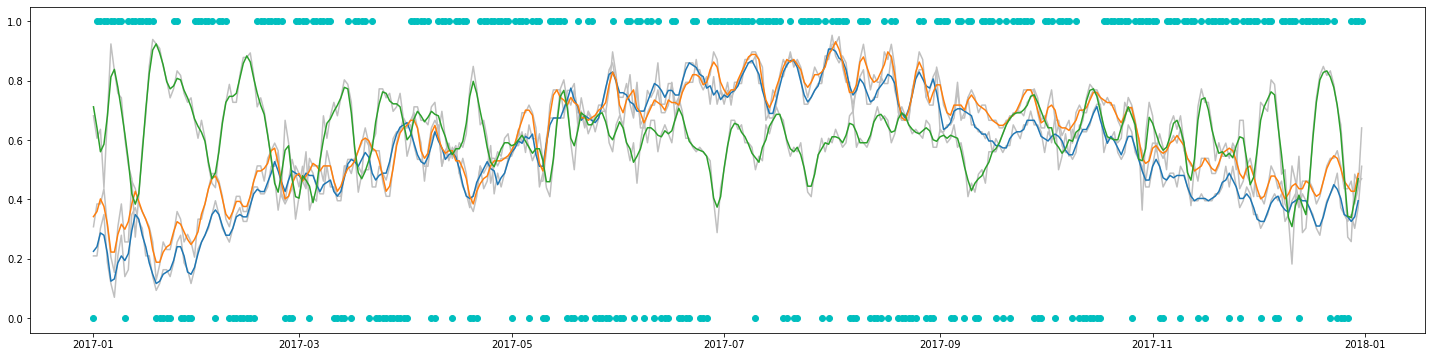

In [0]:
start_date = '2017-01-01'
end_date = '2017-12-31'

plt.figure(figsize = (25, 6))
plt.plot(selected_df[start_date:end_date], 'silver')
plt.plot(average[start_date:end_date])
plt.plot(df_norm['Precip[0-1]'][start_date:end_date], 'oc')
plt.show()

Finally, concatenate continuous value columns with precipitaion and store the dataset for later use.

In [0]:
all_features = pd.concat((average, df_norm['Precip[0-1]']), axis=1).dropna()
all_features

,Temp[av],DPoint[av],SLPress[av],Precip[0-1]
2001-01-02,0.279070,0.393162,0.500000,1.0
2001-01-03,0.310078,0.444444,0.479798,1.0
2001-01-04,0.341085,0.478632,0.469697,1.0
2001-01-05,0.395349,0.521368,0.434343,1.0
2001-01-06,0.441860,0.547009,0.454545,1.0
...,...,...,...,...
2017-12-26,0.348837,0.461538,0.474747,0.0
2017-12-27,0.341085,0.444444,0.343434,0.0
2017-12-28,0.325581,0.427350,0.338384,1.0
2017-12-29,0.341085,0.427350,0.398990,1.0


In [0]:
TESTING_SET_LEN = 365
training_df = all_features[:-TESTING_SET_LEN]
testing_df = all_features[-TESTING_SET_LEN:]

In [0]:
OUT_PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/'
testing_df.to_pickle(OUT_PATH + 'testing_set_temp_dp_press.p')
training_df.to_pickle(OUT_PATH + 'training_set_temp_dp_press.p')
data_bounds.to_pickle(OUT_PATH + 'data_bounds.p')